# CNN для задач классификации

## Загрузка датасета

In [1]:
import tensorflow as tf

classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

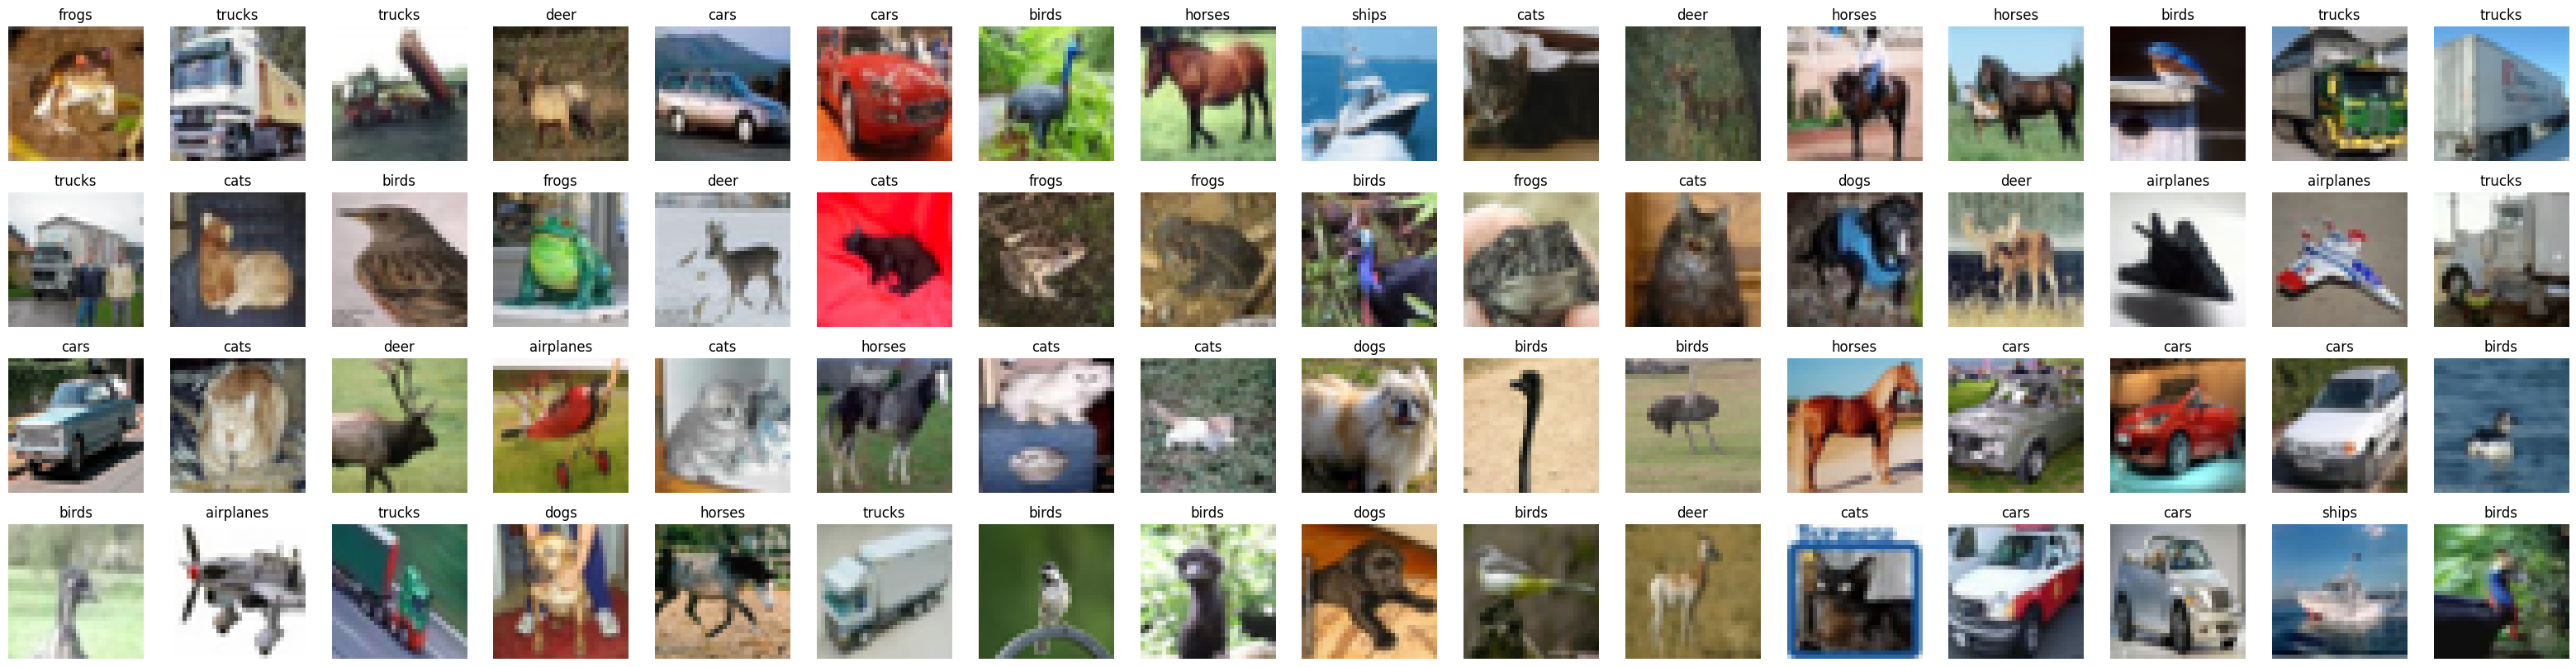

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(40,10), ncols=16, nrows=4)

for i in range(64):
  axes[i // 16, i % 16].imshow(x_train[i])
  axes[i // 16, i % 16].title.set_text(classes[y_train[i][0]])
  axes[i // 16, i % 16].axis('off')
plt.show()

In [3]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42) 

## Предобработка

In [5]:
x_train.dtype, np.max(x_train)

(dtype('uint8'), 255)

In [6]:
x_train = (x_train / np.max(x_train)).astype('float32')
x_val = (x_val / np.max(x_val)).astype('float32')
x_test = (x_test / np.max(x_test)).astype('float32')
x_train[0]

array([[[0.21960784, 0.19607843, 0.16470589],
        [0.23137255, 0.2       , 0.16078432],
        [0.27450982, 0.25490198, 0.2       ],
        ...,
        [0.5411765 , 0.6039216 , 0.5803922 ],
        [0.56078434, 0.61960787, 0.6       ],
        [0.6156863 , 0.65882355, 0.64705884]],

       [[0.21568628, 0.19607843, 0.14901961],
        [0.24705882, 0.22745098, 0.18431373],
        [0.31764707, 0.3019608 , 0.25490198],
        ...,
        [0.5294118 , 0.58431375, 0.5568628 ],
        [0.67058825, 0.73333335, 0.7176471 ],
        [0.6392157 , 0.69411767, 0.69411767]],

       [[0.2509804 , 0.24313726, 0.18431373],
        [0.3137255 , 0.29803923, 0.2627451 ],
        [0.31764707, 0.30588236, 0.27058825],
        ...,
        [0.64705884, 0.7019608 , 0.6666667 ],
        [0.7607843 , 0.827451  , 0.8117647 ],
        [0.57254905, 0.62352943, 0.63529414]],

       ...,

       [[0.1764706 , 0.16078432, 0.13333334],
        [0.19607843, 0.18039216, 0.14509805],
        [0.2627451 , 0

In [7]:
def to_categorical(labels):
  n_classes = len(np.unique(labels))
  ohe = np.zeros((labels.shape[0], n_classes))
  for i in range(labels.shape[0]):
    ohe[i, labels[i][0]] = 1
  return ohe.astype('float32')


y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

In [8]:
y_train[0], y_train_ohe[0]

(array([6], dtype=uint8),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32))

## Инициализация модели

In [9]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam, Adam


cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), padding='same', activation='ReLU', input_shape=x_train[0].shape))
cnn_model.add(Conv2D(32, (3, 3), padding='same', activation='ReLU'))
cnn_model.add(MaxPool2D((2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='ReLU'))
cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='ReLU'))
cnn_model.add(MaxPool2D((2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='ReLU'))
cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='ReLU'))
cnn_model.add(MaxPool2D((2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='ReLU'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(y_train_ohe[0].shape[0], activation='softmax'))

cnn_model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

## Обучение

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

history_cnn = cnn_model.fit(x_train, y_train_ohe, validation_data=(x_val, y_val_ohe),
                            epochs=1000, batch_size=128,
                            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], 
                            verbose=1)

Epoch 1/1000
313/313 [==============================] - 14s 22ms/step - loss: 1.6956 - accuracy: 0.3722 - val_loss: 1.2780 - val_accuracy: 0.5327
Epoch 2/1000
313/313 [==============================] - 6s 18ms/step - loss: 1.1944 - accuracy: 0.5748 - val_loss: 0.9952 - val_accuracy: 0.6455
Epoch 3/1000
313/313 [==============================] - 6s 19ms/step - loss: 0.9851 - accuracy: 0.6543 - val_loss: 0.8637 - val_accuracy: 0.6954
Epoch 4/1000
313/313 [==============================] - 6s 19ms/step - loss: 0.8508 - accuracy: 0.7015 - val_loss: 0.8184 - val_accuracy: 0.7073
Epoch 5/1000
313/313 [==============================] - 6s 18ms/step - loss: 0.7591 - accuracy: 0.7328 - val_loss: 0.7312 - val_accuracy: 0.7435
Epoch 6/1000
313/313 [==============================] - 6s 19ms/step - loss: 0.6919 - accuracy: 0.7568 - val_loss: 0.6711 - val_accuracy: 0.7658
Epoch 7/1000
313/313 [==============================] - 6s 18ms/step - loss: 0.6279 - accuracy: 0.7792 - val_loss: 0.7041 - val_a

## Оцека результатов

In [11]:
cnn_loss, cnn_acc = cnn_model.evaluate(x_test, y_test_ohe)

313/313 [==============================] - 1s 3ms/step - loss: 0.5965 - accuracy: 0.8021


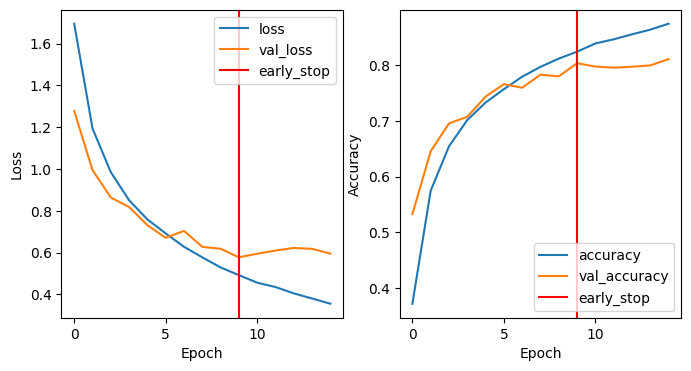

In [12]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, nrows=1)

axes[0].plot(history_cnn.history['loss'], label='loss')
axes[0].plot(history_cnn.history['val_loss'], label='val_loss')
axes[0].axvline(np.argmin(history_cnn.history['val_loss']), color = 'r', label='early_stop')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history_cnn.history['accuracy'], label='accuracy')
axes[1].plot(history_cnn.history['val_accuracy'], label='val_accuracy')
axes[1].axvline(np.argmin(history_cnn.history['val_loss']), color = 'r', label='early_stop')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()

In [13]:
pred_cnn = cnn_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


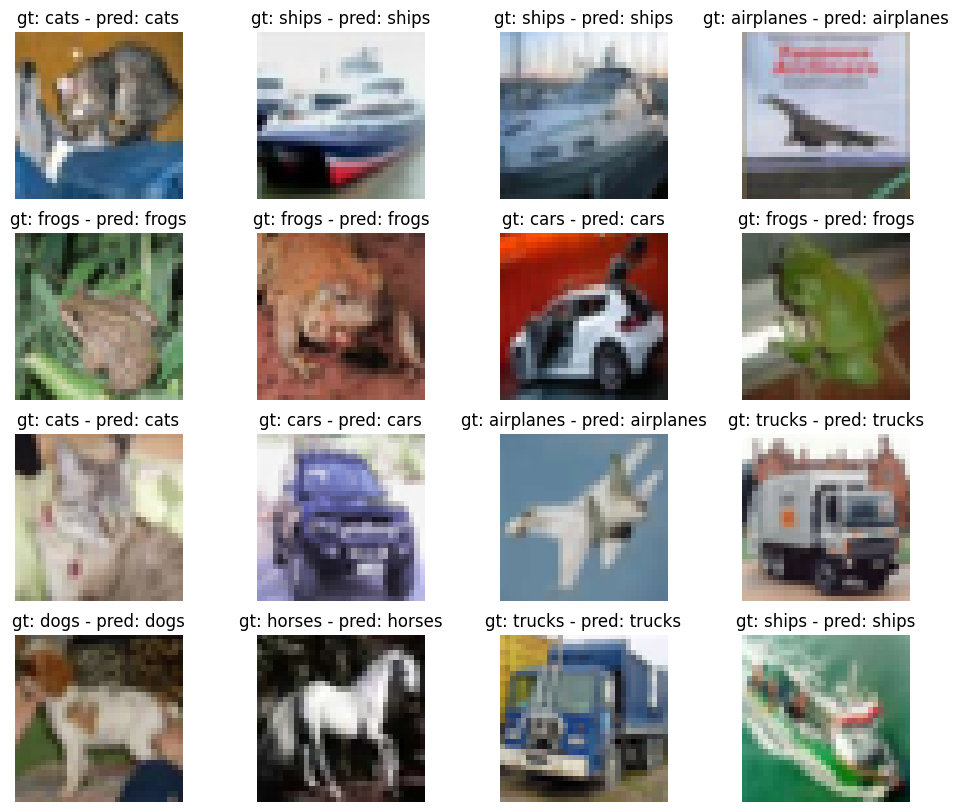

In [14]:
fig, axes = plt.subplots(figsize=(12, 10), ncols=4, nrows=4)

for i in range(16):
  axes[i // 4, i % 4].imshow(x_test[i])
  axes[i // 4, i % 4].title.set_text(f'gt: {classes[np.argmax(y_test_ohe[i])]} - pred: {classes[np.argmax(pred_cnn[i])]}' )
  axes[i // 4, i % 4].axis('off')
plt.show()

# Transfer learning

## Инициализация модели

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_cnn = VGG16(weights='imagenet', include_top=False, input_shape=x_train[0].shape)
vgg16_cnn.trainable = False

In [16]:
transfered_model = Sequential()

transfered_model.add(vgg16_cnn)

transfered_model.add(Flatten())

transfered_model.add(Dense(128, activation='ReLU'))
transfered_model.add(Dropout(0.2))
transfered_model.add(Dense(y_train_ohe[0].shape[0], activation='softmax'))

transfered_model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
transfered_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14,781,642
Trainable params: 66,954
Non-trainable params: 14,714,688
_________________________________________________________________


## Обучение

In [17]:
history_transfered = transfered_model.fit(x_train, y_train_ohe, validation_data=(x_val, y_val_ohe),
                                          epochs=1000, batch_size=128,
                                          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], 
                                          verbose=1)

Epoch 1/1000
313/313 [==============================] - 12s 32ms/step - loss: 1.5629 - accuracy: 0.4548 - val_loss: 1.3062 - val_accuracy: 0.5541
Epoch 2/1000
313/313 [==============================] - 9s 28ms/step - loss: 1.2932 - accuracy: 0.5489 - val_loss: 1.2223 - val_accuracy: 0.5767
Epoch 3/1000
313/313 [==============================] - 8s 25ms/step - loss: 1.2267 - accuracy: 0.5734 - val_loss: 1.1868 - val_accuracy: 0.5945
Epoch 4/1000
313/313 [==============================] - 8s 25ms/step - loss: 1.1831 - accuracy: 0.5843 - val_loss: 1.1633 - val_accuracy: 0.5960
Epoch 5/1000
313/313 [==============================] - 8s 24ms/step - loss: 1.1537 - accuracy: 0.5975 - val_loss: 1.1465 - val_accuracy: 0.6039
Epoch 6/1000
313/313 [==============================] - 9s 28ms/step - loss: 1.1300 - accuracy: 0.6044 - val_loss: 1.1381 - val_accuracy: 0.6040
Epoch 7/1000
313/313 [==============================] - 8s 24ms/step - loss: 1.1056 - accuracy: 0.6143 - val_loss: 1.1249 - val_a

## Сравнение результатов

In [18]:
transfered_loss, transfered_acc = transfered_model.evaluate(x_test, y_test_ohe, verbose=0)
print(f'\t\tloss\tacc\n' +
      f'transfered\t{round(transfered_loss, 2)}\t{round(transfered_acc, 2)}\n' + 
      f'cnn      \t{round(cnn_loss, 2)}\t{round(cnn_acc, 2)}')

		loss	acc
transfered	1.12	0.61
cnn      	0.6	0.8


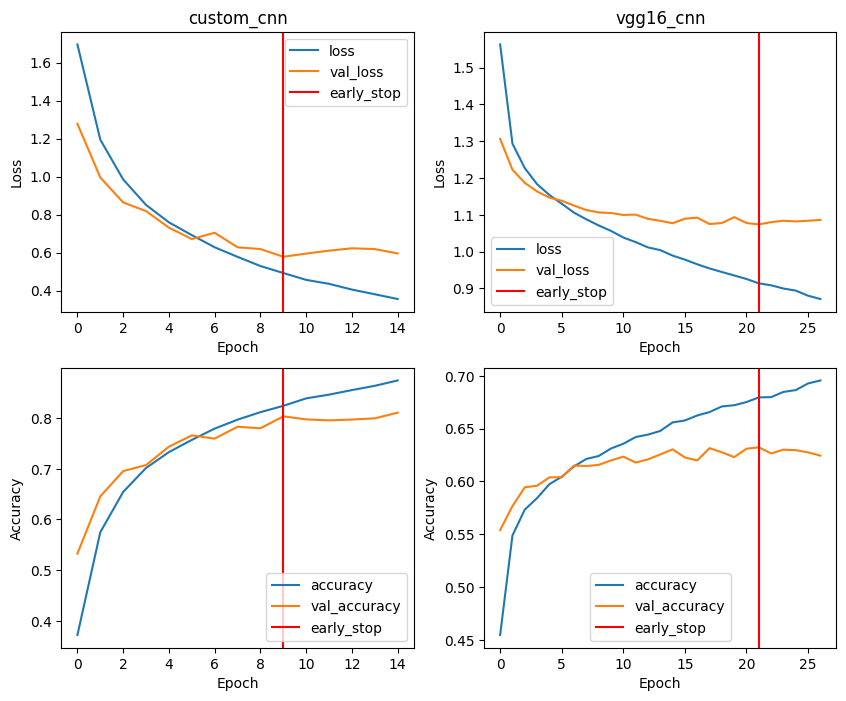

In [19]:
fig, axes = plt.subplots(figsize=(10, 8), ncols=2, nrows=2)

models = ['custom_cnn', 'vgg16_cnn']
for i, history in enumerate([history_cnn, history_transfered]):

  axes[0, i].title.set_text(models[i])
  axes[0, i].plot(history.history['loss'], label='loss')
  axes[0, i].plot(history.history['val_loss'], label='val_loss')
  axes[0, i].axvline(np.argmin(history.history['val_loss']), color = 'r', label='early_stop')
  axes[0, i].set_xlabel("Epoch")
  axes[0, i].set_ylabel("Loss")
  axes[0, i].legend()
  axes[1, i].plot(history.history['accuracy'], label='accuracy')
  axes[1, i].plot(history.history['val_accuracy'], label='val_accuracy')
  axes[1, i].axvline(np.argmin(history.history['val_loss']), color = 'r', label='early_stop')
  axes[1, i].set_xlabel("Epoch")
  axes[1, i].set_ylabel("Accuracy")
  axes[1, i].legend()

plt.show()

In [20]:
pred_transfered = transfered_model.predict(x_test)

313/313 [==============================] - 2s 7ms/step


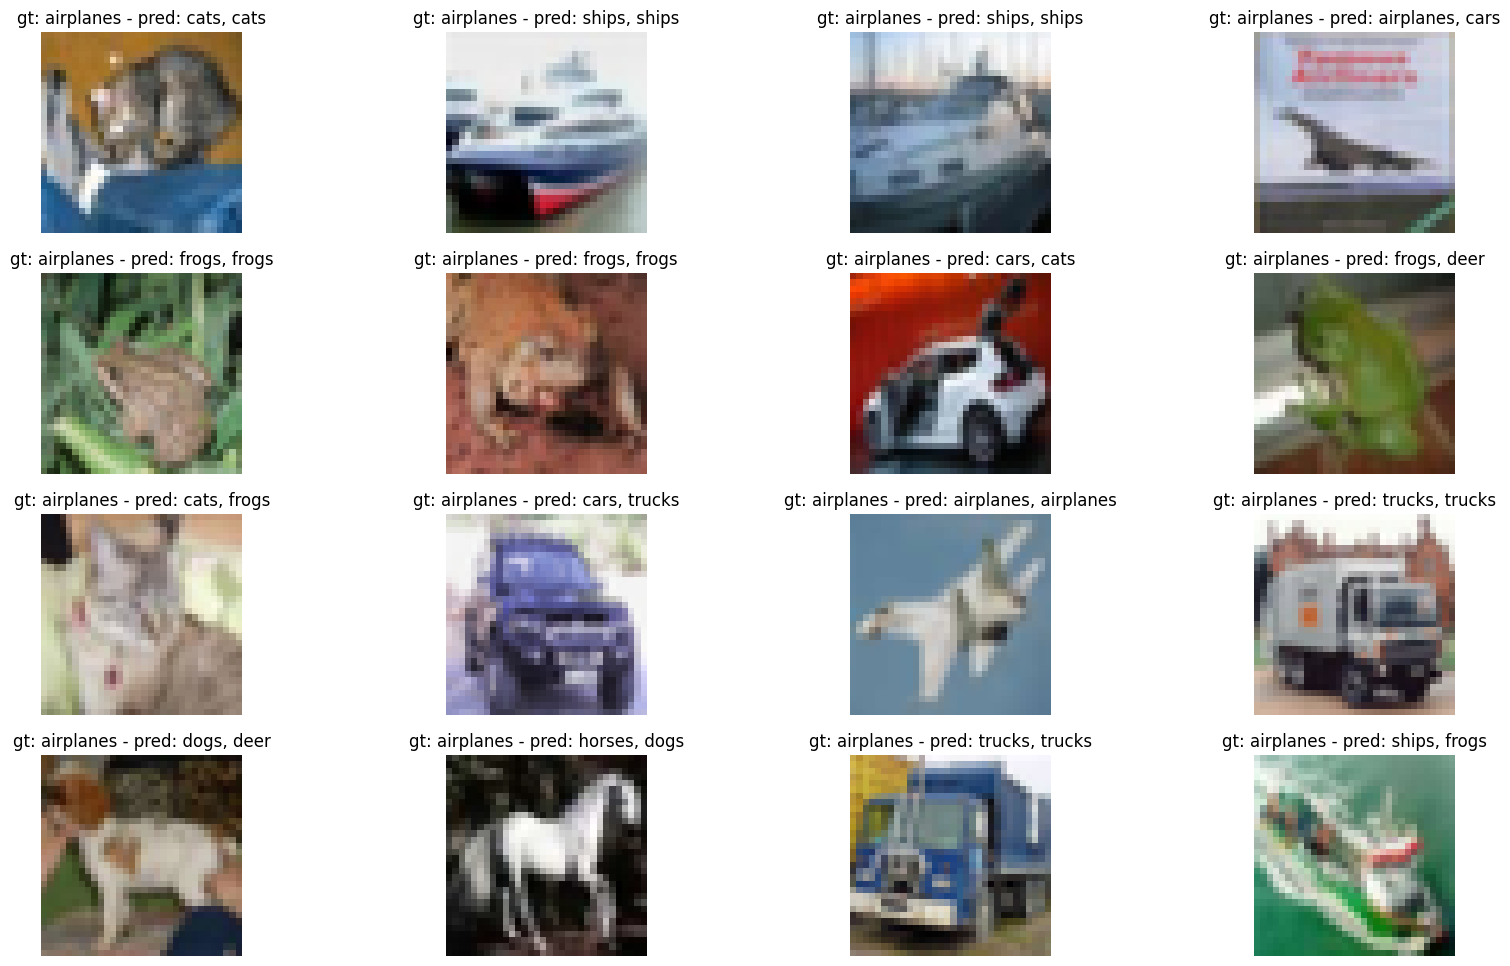

In [21]:
fig, axes = plt.subplots(figsize=(20, 12), ncols=4, nrows=4)

for i in range(16):
  axes[i // 4, i % 4].imshow(x_test[i])
  padding = len('gt: {classes[np.argmax(y_test[i])]} - ')
  axes[i // 4, i % 4].title.set_text(f'gt: {classes[np.argmax(y_test[i])]} - pred: {classes[np.argmax(pred_cnn[i])]}, {classes[np.argmax(pred_transfered[i])]}' )
  axes[i // 4, i % 4].axis('off')
plt.show()